# Random Sampling on Random Forest Classification Tasks
---

The experiments documented in this series analyze the effects of random sampling on Random Forest Classification tasks.

# Experiment Setup

The cells below set up the basic artifacts for the experiments implemented here.

In [1]:
################################################################################################################
# Run the first 3 cells before running the experiments.
################################################################################################################
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sampling.BasicLeverageScoresSampler import BasicLeverageScoresSampler
from sampling.RandomSampler import RandomSampler
from utilities.Stopwatch import Stopwatch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
################################################################################################################
# Plotting functions.
################################################################################################################

SERIES_BLUE = '#0066cc'
SERIES_ORANGE = '#ff3300'

def plot_individualized(accuracies, training_times, type, time_scale, autoscale = False):
    fig1, ax1 = plt.subplots(figsize=(5, 5))

    x = np.arange(1, len(accuracies) + 1)
    width = 0.35

    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color=SERIES_ORANGE, zorder=1)
    ax1.set_ylabel('Accuracy', color=SERIES_ORANGE)
    ax1.tick_params(axis='y', labelcolor=SERIES_ORANGE)
    ax1.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, zorder=0)
    ax1.set_axisbelow(True)

    ax1_twin = ax1.twinx()
    bars2 = ax1_twin.bar(x + width/2, training_times, width, label='Training Time', color=SERIES_BLUE, zorder=1)
    ax1_twin.set_ylabel(f"Training Time ({time_scale})", color=SERIES_BLUE)
    ax1_twin.tick_params(axis='y', labelcolor=SERIES_BLUE)

    if not autoscale:
        ax1_twin.set_ybound(0, 2.2)

    ax1.set_xlabel('Run')
    ax1.set_title(f"{type}\nAccuracy and Training Time for {len(accuracies)} Runs\n\n")
    ax1.set_xticks(x)

    if not autoscale:
        ax1.set_ybound(0, 1.1)

    ax1.legend(bbox_to_anchor=(0, 1), loc='lower left')
    ax1_twin.legend(bbox_to_anchor=(1, 1), loc='lower right')
    ax1_twin.set_axisbelow(True)

    plt.tight_layout()
    
    plt.show()


def plot_mean(accuracies, training_times, type, time_scale, autoscale = False):
    fig2, ax2 = plt.subplots(figsize=(5, 5))

    mean1, std1 = np.mean(accuracies), np.std(accuracies)
    mean2, std2 = np.mean(training_times), np.std(training_times)
    median1, median2 = np.median(accuracies), np.median(training_times)
    q1_1, q3_1 = np.percentile(accuracies, [25, 75])
    q1_2, q3_2 = np.percentile(training_times, [25, 75])

    ax2.bar(-0.2, mean1, width=0.4, color=SERIES_ORANGE, label='Accuracy')
    ax2.errorbar(-0.2, mean1, yerr=[[max(0, mean1-q1_1)], [max(0, q3_1-mean1)]], capsize=10, color='black')
    ax2.plot(-0.2, median1, marker='s', color='black', markersize=8)
    ax2.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, zorder=0)
    ax2.set_axisbelow(True)

    if not autoscale:
        ax2.set_ybound(0, 1.1)

    ax2_twin = ax2.twinx()
    ax2_twin.bar(0.2, mean2, width=0.4, color=SERIES_BLUE, label='Training Time')
    ax2_twin.errorbar(0.2, mean2, yerr=[[max(0, mean2-q1_2)], [max(0, q3_2-mean2)]], capsize=10, color='black')
    ax2_twin.plot(0.2, median2, marker='s', color='black', markersize=8)
    ax2_twin.set_axisbelow(True)

    if not autoscale:
        ax2_twin.set_ybound(0, 2.2)

    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylabel('Accuracy', color=SERIES_ORANGE)
    ax2_twin.set_ylabel(f"Training Time ({time_scale})", color=SERIES_BLUE)
    ax2.tick_params(axis='y', labelcolor=SERIES_ORANGE)
    ax2_twin.tick_params(axis='y', labelcolor=SERIES_BLUE)
    ax2.set_title(f"{type}\nPerformance Summary\n\n")
    ax2.set_xticks([])

    ax2.text(-0.15, mean1, f'{mean1:.2f} [{std1:.2f}]', ha='left', va='bottom', color='black')
    ax2_twin.text(0.25, mean2, f'{mean2:.2f} [{std2:.2f}]', ha='left', va='bottom', color='black')

    ax2.legend(bbox_to_anchor=(0, 1), loc='lower left')
    ax2_twin.legend(bbox_to_anchor=(1, 1), loc='lower right')

    plt.tight_layout()
    
    plt.show()

def plot_results(accuracies, training_times, type, time_scale, autoscale = False):
    plot_individualized(accuracies, training_times, type, time_scale, autoscale)
    plot_mean(accuracies, training_times, type, time_scale, autoscale)

In [11]:
################################################################################################################
# Programming experiments.
################################################################################################################

def run_experiment13(X, y, n_runs):
    accuracies = []
    training_times = []

    for _ in range(n_runs):
        # Starting timer.
        training_stopwatch = Stopwatch()
        training_stopwatch.start()

        # Splitting the data into training and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Resuming timer.
        training_stopwatch.start()

        # Initializing and training the model.
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees
        rf_classifier.fit(X_train, y_train)

        # Stopping timer.
        training_time = training_stopwatch.stop()

        # Making predictions on the test set.
        predictions = rf_classifier.predict(X_test)

        # Evaluating model.
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        training_times.append(training_time)

    return accuracies, training_times

def run_experiment14(X, y, n_runs):
    accuracies = []
    training_times = []

    for _ in range(n_runs):
        # Starting timer.
        training_stopwatch = Stopwatch()
        training_stopwatch.start()

        # Sampling data.
        sampler = BasicLeverageScoresSampler()
        X_sampled, y_sampled = sampler.sample(X, y, 0.2) # Sampling 20% of the data.

        # Splitting the data into training and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

        # Resuming timer.
        training_stopwatch.start()

        # Initializing and training the model.
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees
        rf_classifier.fit(X_train, y_train)

        # Stopping timer.
        training_time = training_stopwatch.stop()

        # Making predictions on the test set.
        predictions = rf_classifier.predict(X_test)

        # Evaluating model.
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        training_times.append(training_time)

    return accuracies, training_times

def run_experiment15(X, y, n_runs):
    accuracies = []
    training_times = []

    for _ in range(n_runs):
        # Starting timer.
        training_stopwatch = Stopwatch()
        training_stopwatch.start()

        # Sampling data.
        sampler = RandomSampler()
        X_sampled, y_sampled = sampler.sample(X, y, 0.2) # Sampling 20% of the data.

        # Splitting the data into training and test sets.
        X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

        # Resuming timer.
        training_stopwatch.start()

        # Initializing and training the model.
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees
        rf_classifier.fit(X_train, y_train)

        # Stopping timer.
        training_time = training_stopwatch.stop()

        # Making predictions on the test set.
        predictions = rf_classifier.predict(X_test)

        # Evaluating model.
        accuracy = accuracy_score(y_test, predictions)

        accuracies.append(accuracy)
        training_times.append(training_time)

    return accuracies, training_times


# Experiments
---

## Experiment 13: SciKit-Learn's `RandomForestClassifier` Class, Non-Sampled

Here, we analyze the performance of the `RandomForestClassifier` class without sampling. The code is run 1000 times.

All experiments are conducted with the [Wine dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html).

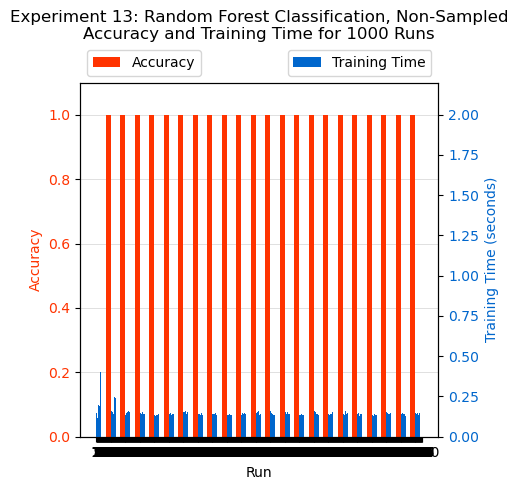

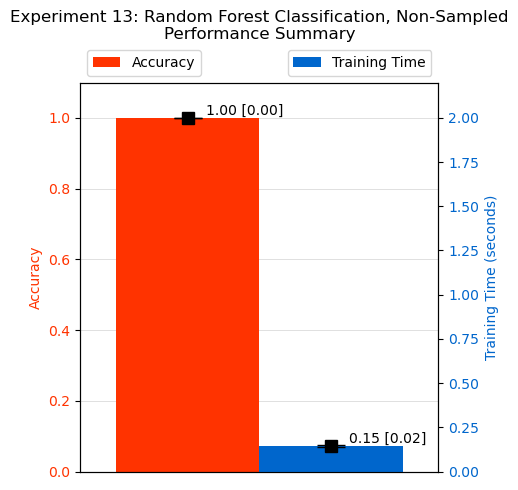

In [6]:
# Loading the dataset.
data = load_wine()
X, y = data.data, data.target

# Running the experiment.
accuracies, training_times = run_experiment13(X, y, 1000)

# Plotting the results.
plot_results(accuracies, training_times, 'Experiment 13: Random Forest Classification, Non-Sampled', 'seconds')

## Experiment 14: SciKit-Learn's `RandomForestClassifier` Class, Sampled with `BasicLeverageScoresSampler`

Here, we analyze the performance of the `RandomForestClassifier` class when 20% of the dataset is sampled with `BasicLeverageScoresSampler`. The code is run 1000 times.

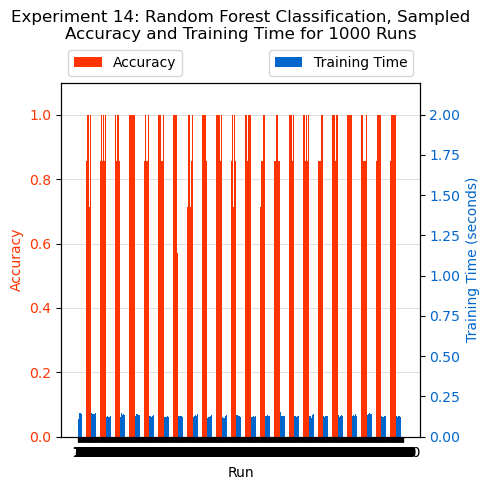

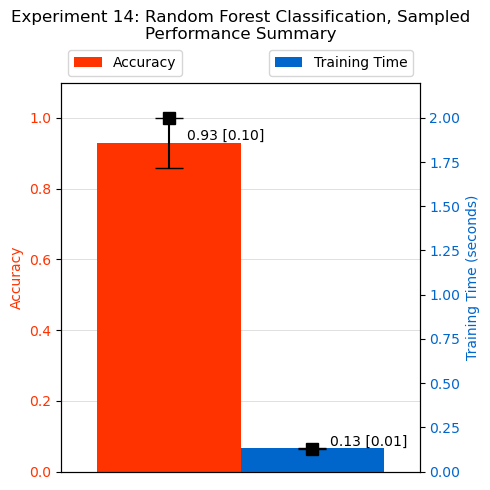

In [10]:
# Loading the dataset.
data = load_wine()
X, y = data.data, data.target

# Running the experiment.
accuracies, training_times = run_experiment14(X, y, 1000)

# Plotting the results.
plot_results(accuracies, training_times, 'Experiment 14: Random Forest Classification, Sampled', 'seconds')

## Experiment 15: SciKit-Learn's `RandomForestClassifier` Class, Sampled with `RandomSampler`

Here, we analyze the performance of SciKit-Learn's `RandomForestClassifier` class when 20% of the dataset is sampled with `RandomSampler`. The code is run 1000 times.

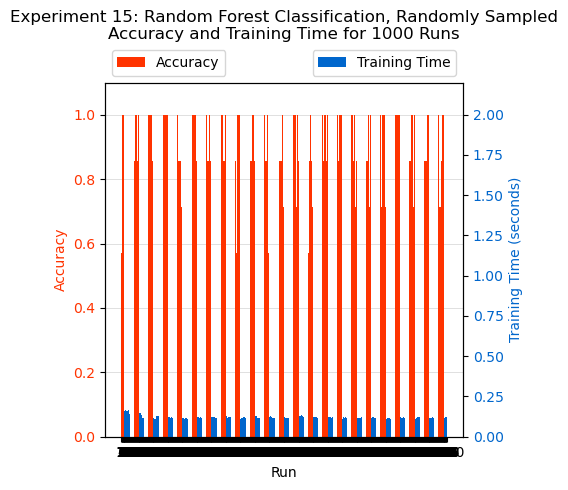

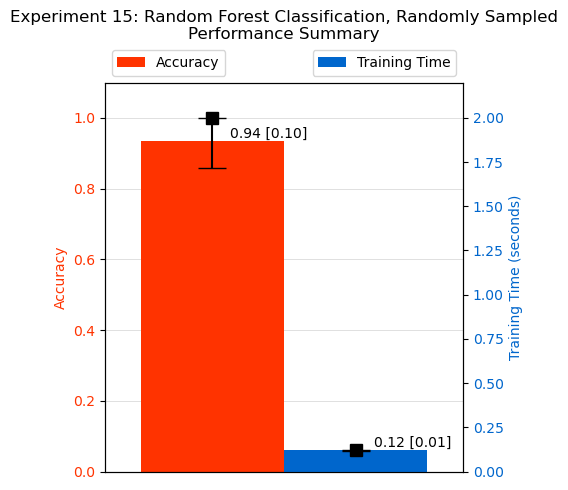

In [15]:
data = load_wine()
X = data.data
y = data.target

accuracies, training_times = run_experiment15(X, y, 1000)
plot_results(accuracies, training_times, "Experiment 15: Random Forest Classification, Randomly Sampled", 'seconds')